- 탐색적데이터 분석
- y: 'class' , 1:부정(positive)
- train_test_split - 7:3, stratify
- 다양한 분류 모델링
- Metric: Accuracy, recall
- 성능이 가장 좋은 모델 선택

# Kaggle 신용카드 부정 탐지

https://www.kaggle.com/mlg-ulb/creditcardfraud

## Credit Card Fraud Detection
- creditcard.csv(284,807 * 31)
- class: 0(정상), 1(사기)
- 사기검출(Fraud Detection), 이상탐지(Anomaly Detection)

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import graphviz

from scipy import stats

from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE

## 1. Google Drive Mount
- 'creditCardFraud.zip'파일을 구글드라이브에 업로드 후 진행
- 압축된 상태로 마운트해서 불러오면 훨씬 빠르다

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


- 마운트 결과 확인

In [ ]:
!ls -l '/content/drive/My Drive/Colab Notebooks/datasets/creditCardFraud.zip'

-rw------- 1 root root 68787205 Mar  9 04:06 '/content/drive/My Drive/Colab Notebooks/datasets/creditCardFraud.zip'


## Data Preprocessing

### 1) Unzip 'creditCardFraud.zip'
- colab 파일시스템에 'creditcard.csv' 파일 생성

In [ ]:
!unzip /content/drive/My\ Drive/Colab\ Notebooks/datasets/creditCardFraud.zip

Archive:  /content/drive/My Drive/Colab Notebooks/datasets/creditCardFraud.zip
  inflating: creditcard.csv          
  inflating: __MACOSX/._creditcard.csv  


- creditcard.csv 파일 확인

In [ ]:
!ls -l

total 147308
-rw-rw-r-- 1 root root 150828752 Sep 19  2019 creditcard.csv
drwx------ 5 root root      4096 Mar 10 04:38 drive
drwxr-xr-x 2 root root      4096 Mar 10 04:39 __MACOSX
drwxr-xr-x 1 root root      4096 Mar  5 14:37 sample_data


### 2) 데이터 읽어오기

- pandas DataFrame

In [ ]:
%%time

DF = pd.read_csv('creditcard.csv')

DF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

## EDA

In [ ]:
DF.head()

# 민감정보 처리
# 금융, 신용, 의료정보 등은 알아보지 못하게 처리되어 있음
# 값: scaling(standardization 되어있음)
# 어떤 정보인지 알려주고 싶지 않을 때
# 민감한 정보는 철저히 비식별화되어 처리되는 경우가 많음

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [ ]:
DF.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,1.768627e-15,9.170318e-16,-1.810658e-15,1.693438e-15,1.479045e-15,3.482336e-15,1.392007e-15,-7.528491e-16,4.328772e-16,9.049732e-16,5.085503e-16,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


#### (1) 상관계수 확인

In [ ]:
pearsonr = pd.DataFrame(data = None,
                        columns = ['column' , 'pearsonr'])

for col in DF.columns :
  if col == 'Class' : continue
  pearsonr = pearsonr.append({'column' : col , 'pearsonr' : stats.pearsonr(DF[col], DF.Class)[0]},
                             ignore_index = True)

  print('%s - Class 상관계수 :' % (col) , stats.pearsonr(DF[col], DF.Class)[0])

Time - Class 상관계수 : -0.012322570929245763
V1 - Class 상관계수 : -0.10134729859508598
V2 - Class 상관계수 : 0.09128865034462008
V3 - Class 상관계수 : -0.1929608270674153
V4 - Class 상관계수 : 0.133447486239006
V5 - Class 상관계수 : -0.09497429899144921
V6 - Class 상관계수 : -0.04364316069996437
V7 - Class 상관계수 : -0.18725659151429974
V8 - Class 상관계수 : 0.019875123914794623
V9 - Class 상관계수 : -0.09773268607407976
V10 - Class 상관계수 : -0.21688294364102956
V11 - Class 상관계수 : 0.15487564474394916
V12 - Class 상관계수 : -0.2605929248772196
V13 - Class 상관계수 : -0.004569778799461309
V14 - Class 상관계수 : -0.30254369580440715
V15 - Class 상관계수 : -0.004223402267856705
V16 - Class 상관계수 : -0.1965389403040205
V17 - Class 상관계수 : -0.32648106724371784
V18 - Class 상관계수 : -0.11148525388904237
V19 - Class 상관계수 : 0.034783013036515126
V20 - Class 상관계수 : 0.020090324196975567
V21 - Class 상관계수 : 0.04041338061057595
V22 - Class 상관계수 : 0.0008053175052984462
V23 - Class 상관계수 : -0.0026851557402507364
V24 - Class 상관계수 : -0.007220906715952784
V25 - Clas

In [ ]:
pearsonr.sort_values(by = 'pearsonr')

,column,pearsonr
17,V17,-0.326481
14,V14,-0.302544
12,V12,-0.260593
10,V10,-0.216883
16,V16,-0.196539
3,V3,-0.192961
7,V7,-0.187257
18,V18,-0.111485
1,V1,-0.101347
9,V9,-0.097733


In [ ]:
main_col = ['V17' , 'V14' , 'V12' , 'V10' , 'V16' , 'V3' , 'V7' , 'V18' , 'V1' , 
            'V4' , 'V11' , 'Class']

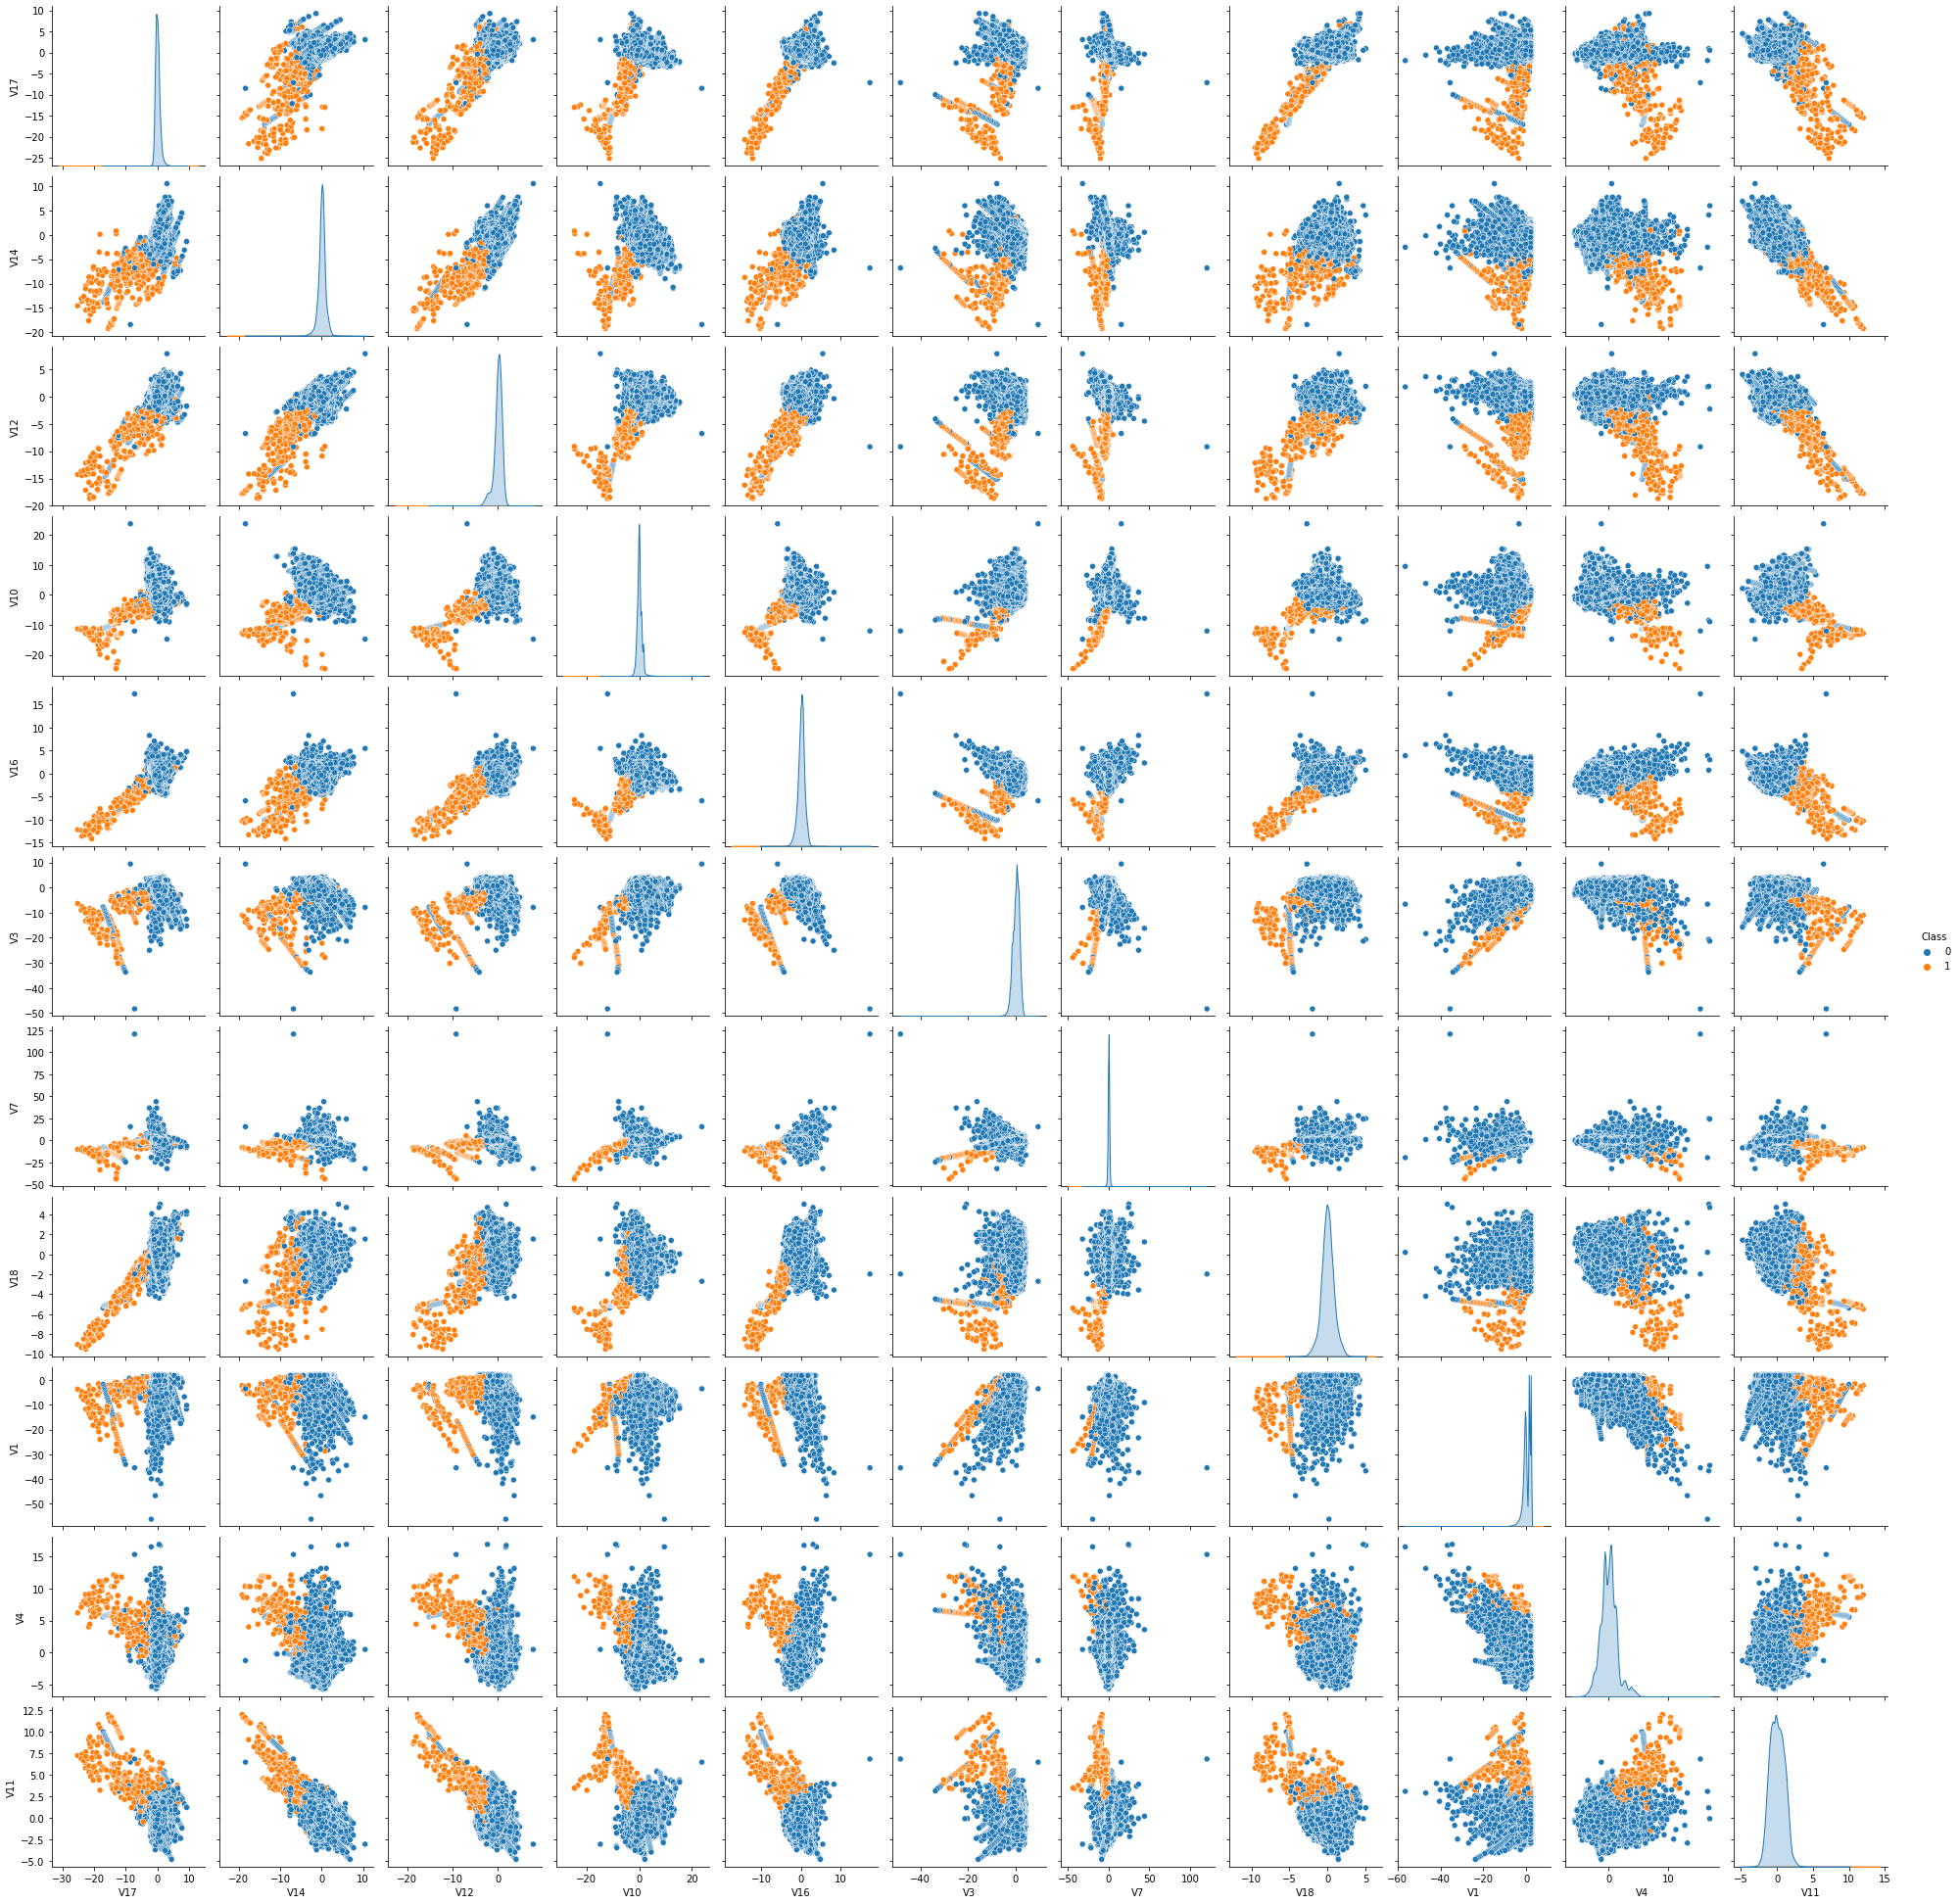

In [ ]:
sns.pairplot(hue = 'Class' , data = DF[main_col])
plt.show()

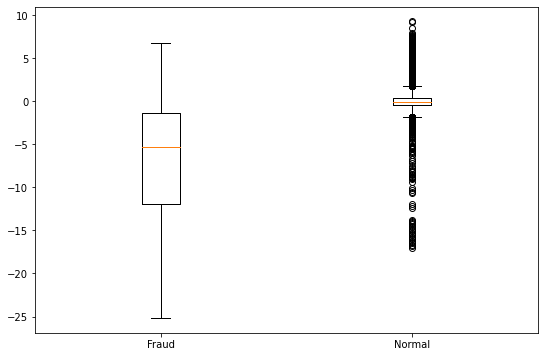

In [ ]:
plt.figure(figsize = (9, 6))
plt.boxplot([DF[DF.Class == 1].V17,
            DF[DF.Class == 0].V17],
            labels = ['Fraud' , 'Normal'])
plt.show()

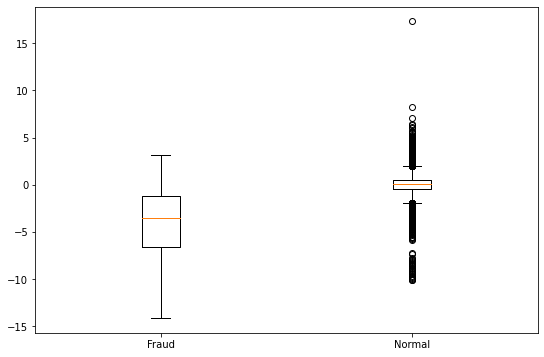

In [ ]:
plt.figure(figsize = (9, 6))
plt.boxplot([DF[DF.Class == 1].V16,
            DF[DF.Class == 0].V16],
            labels = ['Fraud' , 'Normal'])
plt.show()

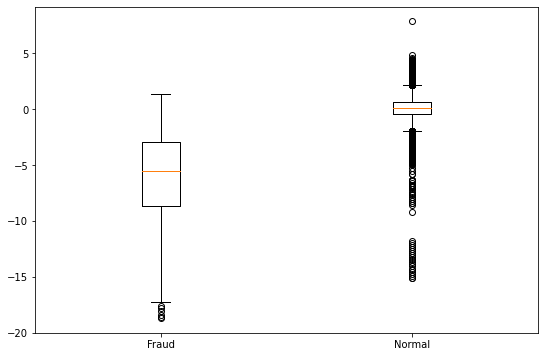

In [ ]:
plt.figure(figsize = (9, 6))
plt.boxplot([DF[DF.Class == 1].V12,
            DF[DF.Class == 0].V12],
            labels = ['Fraud' , 'Normal'])
plt.show()

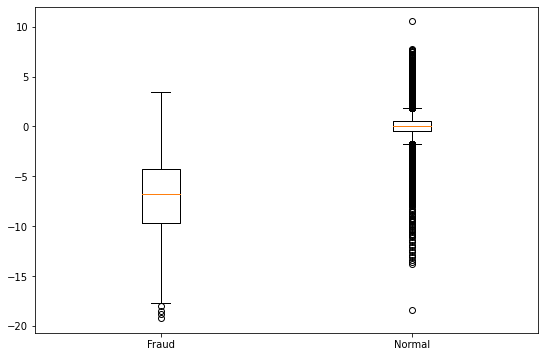

In [ ]:
plt.figure(figsize = (9, 6))
plt.boxplot([DF[DF.Class == 1].V14,
            DF[DF.Class == 0].V14],
            labels = ['Fraud' , 'Normal'])
plt.show()

- 0(정상) Class와 1(사기) Class 개수

In [ ]:
DF.Class.value_counts()

# 정상이 압도적으로 많다

0    284315
1       492
Name: Class, dtype: int64

- 0(정상) Class 와 1(사기) Class 비율

In [ ]:
(DF.Class.value_counts() / DF.shape[0]) * 100

# 한쪽으로 쏠려있는 데이터
# 현실적인 데이터 (불균형 데이터가 매우 많다)

0    99.827251
1     0.172749
Name: Class, dtype: float64

### 1) Time 열(Column) 삭제

In [ ]:
DF.drop('Time', axis = 1, inplace = True)

DF.head(1)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.5516,-0.617801,-0.99139,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0


### 2) train_test_split
- 쏠린 경우에는 stratify를 꼭 주고 하자!

#### (1) All Features

In [ ]:
X = DF.iloc[:, :-1]
y = DF.iloc[:, -1]

X.shape, y.shape

((284807, 29), (284807,))

In [ ]:
DF.columns[:-1]

Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21',
       'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount'],
      dtype='object')

#### (2) Without 'stratify'

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.3,
                                                    random_state = 2045)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((199364, 29), (199364,), (85443, 29), (85443,))

In [ ]:
print('Train Data:' , '\n' , (y_train.value_counts() / y_train.shape[0]) * 100)
print('Test Data:' , '\n' , (y_test.value_counts() / y_test.shape[0]) * 100)

Train Data: 
 0    99.825445
1     0.174555
Name: Class, dtype: float64
Test Data: 
 0    99.831467
1     0.168533
Name: Class, dtype: float64


#### (2-1) With 'stratify'

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.3,
                                                    stratify = y,
                                                    random_state = 2045)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((199364, 29), (199364,), (85443, 29), (85443,))

In [ ]:
print('Train Data:' , '\n' , (y_train.value_counts() / y_train.shape[0]) * 100)
print('Test Data:' , '\n' , (y_test.value_counts() / y_test.shape[0]) * 100)

Train Data: 
 0    99.827451
1     0.172549
Name: Class, dtype: float64
Test Data: 
 0    99.826785
1     0.173215
Name: Class, dtype: float64


#### (3) SMOTE

In [ ]:
OS = SMOTE(random_state = 2045)

X_train_os, y_train_os = OS.fit_sample(X_train, y_train)

X_train_os.shape, y_train_os.shape

((398040, 29), (398040,))

In [ ]:
# 결과를 담을 데이터프레임
df_res = pd.DataFrame(columns = ['model_id' , 'model' , 'accuracy' , 'recall'])

In [ ]:
df_res

,model_id,model,accuracy,recall


##Modeling

### 1) Logistic Regression

In [ ]:
%%time

LR = LogisticRegression(multi_class = 'multinomial',
                        n_jobs = -1)

LR.fit(X_train, y_train)

CPU times: user 113 ms, sys: 228 ms, total: 342 ms
Wall time: 10.8 s


####(1) 성능평가

In [ ]:
ac = accuracy_score(y_test, LR.predict(X_test))
rs = recall_score(y_test, LR.predict(X_test), pos_label = 1)

res = {'model_id' : 'LR' , 'model' : 'Logistic Regression' , 'accuracy' : ac , 'recall' : rs}
df_res = df_res.append(res, ignore_index= True)
df_res

,model_id,model,accuracy,recall
0,RF,Random Forest,0.999614,0.837838
1,GBM,GBM,0.999040,0.635135
2,ABC,AdaBoosting,0.999181,0.628378
3,XGB,XGBoosting,0.999579,0.844595
4,LGBM,LGBM,0.999555,0.817568
5,DT,Decision Tree,0.999298,0.810811
6,LR,Logistic Regression,0.999380,0.750000


### 2) Decision Tree Classifier

In [ ]:
%%time

DT = DecisionTreeClassifier(random_state = 2045)

DT.fit(X_train, y_train)

CPU times: user 20.2 s, sys: 14.8 ms, total: 20.2 s
Wall time: 20.2 s


####(1) 성능평가

In [ ]:
ac = accuracy_score(y_test, DT.predict(X_test))
rs = recall_score(y_test, DT.predict(X_test), pos_label = 1)

res = {'model_id' : 'DT' , 'model' : 'Decision Tree' , 'accuracy' : ac , 'recall' : rs}
df_res = df_res.append(res, ignore_index= True)
df_res

,model_id,model,accuracy,recall
0,RF,Random Forest,0.999614,0.837838
1,GBM,GBM,0.999040,0.635135
2,ABC,AdaBoosting,0.999181,0.628378
3,XGB,XGBoosting,0.999579,0.844595
4,LGBM,LGBM,0.999555,0.817568
5,DT,Decision Tree,0.999298,0.810811


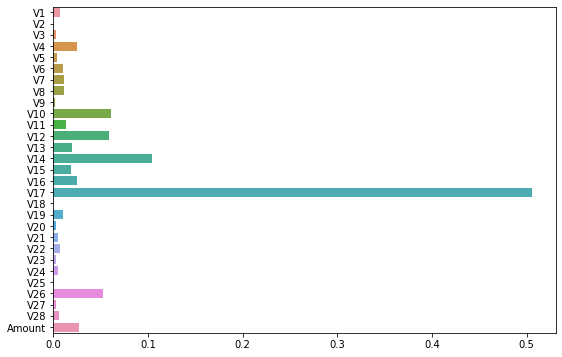

In [ ]:
plt.figure(figsize = (9, 6))
sns.barplot(DT.feature_importances_,
            X.columns)
plt.show()

#### (2) Visualization

In [ ]:
graphviz.Source(export_graphviz(DT,
                                class_names = ['1', '0'],
                                feature_names = X.columns,
                                filled = True))

### 2-1) Decision Tree - with SMOTE
- 데이터가 적을 경우, 데이터를 증폭시킴

In [ ]:
DT = DecisionTreeClassifier(random_state = 2045)

DT.fit(X_train_os, y_train_os)

In [ ]:
ac = accuracy_score(y_test, DT.predict(X_test))
rs = recall_score(y_test, DT.predict(X_test), pos_label = 1)

res = {'model_id' : 'DT2' , 'model' : 'Decision Tree' , 'accuracy' : ac , 'recall' : rs}
df_res = df_res.append(res, ignore_index= True)
df_res

### 

In [ ]:
# precision이 급격히 떨어진다
# 주의) precision이 너무 낮을 경우 실패한 모델링. 쓰면 안된다!


튜닝 LightGBM

### 3) Random Forest Classifier

In [ ]:
RF = RandomForestClassifier(criterion = 'entropy' ,
                            n_estimators = 200,
                            random_state = 2045,
                            n_jobs = -1)

RF.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=2045, verbose=0,
                       warm_start=False)

In [ ]:
RF.feature_importances_

array([0.00963396, 0.01692272, 0.02704254, 0.04308986, 0.01173805,
       0.01045675, 0.02651987, 0.01109815, 0.02210432, 0.10961563,
       0.07136002, 0.0742811 , 0.01076835, 0.18307466, 0.00824284,
       0.04227118, 0.17262751, 0.03376819, 0.01038005, 0.0114876 ,
       0.01504006, 0.00769031, 0.00801518, 0.00756909, 0.00719245,
       0.01367963, 0.01081318, 0.01120979, 0.01230693])

#### (1) 모델성능 평가

In [ ]:
ac = accuracy_score(y_test, RF.predict(X_test))

ac

0.9996137776061234

In [ ]:
confusion_matrix(y_test, RF.predict(X_test))

array([[85286,     9],
       [   24,   124]])

In [ ]:
rs = recall_score(y_test, RF.predict(X_test), pos_label = 1)
rs

0.8378378378378378

In [ ]:
a = {'model_id' : 'RF' , 'model' : 'Random Forest' , 'accuracy' : ac , 'recall' : rs}

In [ ]:
df_res = df_res.append(a, ignore_index= True)

In [ ]:
df_res

,model_id,model,accuracy,recall
0,RF,Random Forest,0.999614,0.837838


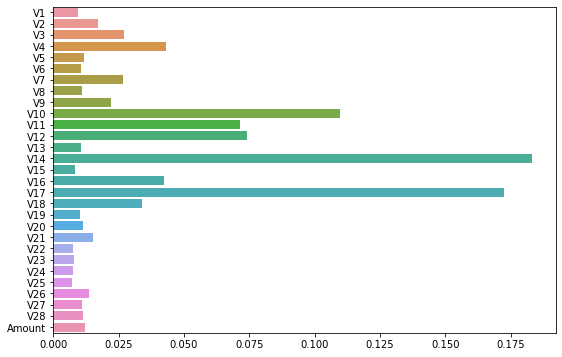

In [ ]:
plt.figure(figsize = (9, 6))
sns.barplot(RF.feature_importances_,
            X.columns)
plt.show()

### 3-1) Random Forest with SMOTE

In [ ]:
RF = RandomForestClassifier(criterion = 'entropy' ,
                            n_estimators = 200,
                            random_state = 2045,
                            n_jobs = -1)

RF.fit(X_train_os, y_train_os)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=-1, oob_score=False, random_state=2045, verbose=0,
                       warm_start=False)

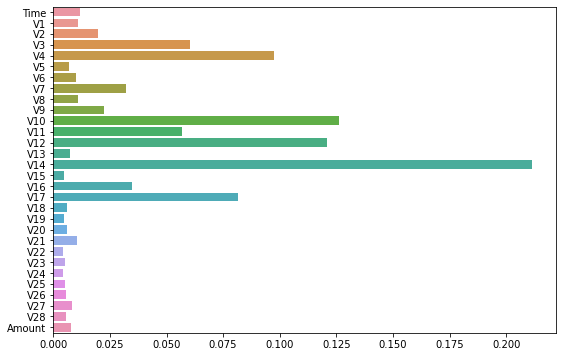

In [ ]:
plt.figure(figsize = (9, 6))
sns.barplot(RF.feature_importances_,
            X.columns)
plt.show()

#### (1) 성능평가

In [ ]:
ac = accuracy_score(y_test, RF.predict(X_test))
rs = recall_score(y_test, RF.predict(X_test), pos_label = 1)
res = {'model_id' : 'RF-SMOTE' , 'model' : 'Random Forest' , 'accuracy' : ac , 'recall' : rs}
df_res = df_res.append(res, ignore_index= True)

In [ ]:
df_res

,model_id,model,accuracy,recall
0,RF-SMOTE,Random Forest,0.999532,0.878378


### 4) GBM Classifier

In [ ]:
%%time

GBC = GradientBoostingClassifier(loss = 'deviance')

GBC.fit(X_train, y_train)

CPU times: user 5min 16s, sys: 175 ms, total: 5min 16s
Wall time: 5min 15s


#### (1) 모델성능 평가

In [ ]:
ac = accuracy_score(y_test, GBC.predict(X_test))
ac

0.9990402958697612

In [ ]:
rs = recall_score(y_test, GBC.predict(X_test), pos_label = 1)
rs

0.6351351351351351

(2) 결과 저장

In [ ]:
res = {'model_id' : 'GBM' , 'model' : 'GBM' , 'accuracy' : ac , 'recall' : rs}
df_res = df_res.append(res, ignore_index= True)
df_res

,model_id,model,accuracy,recall
0,RF,Random Forest,0.999614,0.837838
1,GBM,GBM,0.999040,0.635135


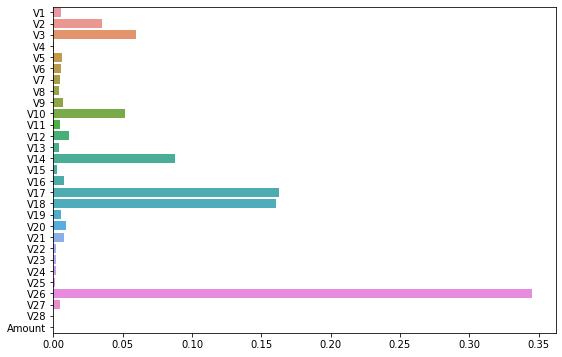

In [ ]:
plt.figure(figsize = (9, 6))
sns.barplot(GBC.feature_importances_,
            X.columns)
plt.show()

### 5) Adaptive Boosting Classifier

In [ ]:
%%time

ABC = AdaBoostClassifier(n_estimators = 1000,
                         learning_rate = 0.001,
                         random_state = 2045)
ABC.fit(X_train, y_train)

CPU times: user 19min 42s, sys: 1.3 s, total: 19min 43s
Wall time: 19min 41s


#### (1) 모델 평가

In [ ]:
ac = accuracy_score(y_test, ABC.predict(X_test))
ac

0.9991807403766253

In [ ]:
rs = recall_score(y_test, ABC.predict(X_test), pos_label = 1)
rs

0.6283783783783784

In [ ]:
res = {'model_id' : 'ABC' , 'model' : 'AdaBoosting' , 'accuracy' : ac , 'recall' : rs}
df_res = df_res.append(res, ignore_index= True)
df_res

,model_id,model,accuracy,recall
0,RF,Random Forest,0.999614,0.837838
1,GBM,GBM,0.999040,0.635135
2,ABC,AdaBoosting,0.999181,0.628378


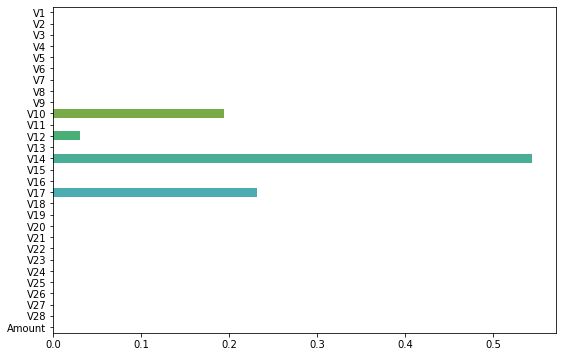

In [ ]:
plt.figure(figsize = (9, 6))
sns.barplot(ABC.feature_importances_,
            X.columns)
plt.show()

### 6) XGBoost Classifier

In [ ]:
XGB = XGBClassifier(booster = 'gbtree')

XGB.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

### (1) 모델평가

In [ ]:
ac = accuracy_score(y_test, XGB.predict(X_test))
ac

0.9995786664794073

In [ ]:
rs = recall_score(y_test, XGB.predict(X_test), pos_label = 1)
rs

0.8445945945945946

In [ ]:
res = {'model_id' : 'XGB2' , 'model' : 'XGBoosting' , 'accuracy' : ac , 'recall' : rs}
df_res = df_res.append(res, ignore_index= True)
df_res

,model_id,model,accuracy,recall
0,RF,Random Forest,0.999614,0.837838
1,GBM,GBM,0.999040,0.635135
2,ABC,AdaBoosting,0.999181,0.628378
3,XGB,XGBoosting,0.999579,0.844595
4,LGBM,LGBM,0.999555,0.817568
5,DT,Decision Tree,0.999298,0.810811
6,LR,Logistic Regression,0.999380,0.750000
7,KNN,K-NN,0.998268,0.000000
8,LGBM2,LGBM,0.999602,0.831081
9,XGB2,XGBoosting,0.999637,0.851351


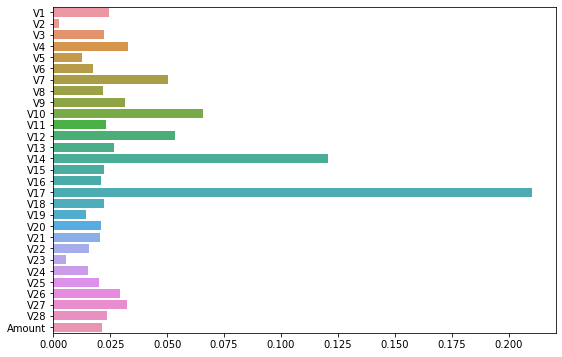

In [ ]:
plt.figure(figsize = (9, 6))
sns.barplot(XGB.feature_importances_,
            X.columns)
plt.show()

### 6-1) XGBoost with SMOTE

In [ ]:
# SMOTE 하며 column명이 날아가므로 재지정을 해주는 과정 필요
DF_XGB = pd.DataFrame(X_train_os, columns = DF.columns[:-1])

In [ ]:
DF_XGB.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,-2.353062,2.719667,-1.442479,-1.739477,0.933258,-1.805955,2.150139,-1.013120,2.343305,3.680172,-0.483947,-0.759588,-1.288094,-0.525955,0.233884,-1.173063,-0.707411,-0.628309,-0.516416,1.448128,-0.232574,0.714511,-0.198012,-0.029094,0.128996,0.046007,0.891105,0.344601,3.78
1,-0.290290,0.411460,-0.406813,-0.471921,1.756346,-1.176621,0.715865,-0.171749,-0.244361,-0.993072,-0.802516,0.242637,0.732015,-1.032850,-0.453912,0.266387,0.255246,-0.195417,-0.156225,0.067899,-0.139295,-0.480183,0.287938,0.499635,-1.251272,-0.040220,0.190796,0.297079,1.98
2,2.124485,-0.107674,-1.509747,0.178449,0.342655,-0.620870,0.159012,-0.260699,0.636639,0.076950,-1.698364,0.009638,0.085085,0.246587,0.134503,0.206288,-0.656522,-0.509472,0.537184,-0.189612,-0.356052,-0.906764,0.208692,-1.007817,-0.167217,0.260335,-0.074221,-0.069843,7.44
3,1.750849,-1.459983,-1.141481,-0.611125,-0.993234,-0.967576,-0.223093,-0.383936,-0.348905,0.634396,-0.559811,0.032901,1.051679,-0.360125,-0.096634,0.799373,0.281546,-1.656215,0.478694,0.463535,0.344616,0.601632,-0.052760,0.049971,-0.123602,-0.186215,-0.049955,-0.015918,237.28
4,2.132471,0.157415,-2.493049,0.328990,0.878038,-1.304422,0.878626,-0.478040,-0.293090,0.463674,0.445132,0.344416,-0.871141,1.146420,-0.873247,-0.470329,-0.458395,0.010702,0.442924,-0.282945,0.283941,0.960182,-0.232440,-0.321288,0.684001,0.730081,-0.131570,-0.108989,0.00


In [ ]:
XGB1 = XGBClassifier(booster = 'gbtree' ,
                    max_depth = 6,
                    n_estimators = 300,
                    n_jobs = -1)

XGB1.fit(DF_XGB, y_train_os)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=None, n_estimators=300, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [ ]:
ac = accuracy_score(y_test, XGB1.predict(X_test))
rs = recall_score(y_test, XGB1.predict(X_test), pos_label = 1)
res = {'model_id' : 'XGB-SMOTE' , 'model' : 'XGBoosting' , 'accuracy' : ac , 'recall' : rs}
df_res = df_res.append(res, ignore_index= True)
df_res

,model_id,model,accuracy,recall
0,XGB-SMOTE,XGBoosting,0.999579,0.844595
1,XGB-SMOTE,XGBoosting,0.999450,0.885135


### 7) LighGBM Classifier

In [ ]:
%%time

LGB = LGBMClassifier(n_estimators = 1000,
                     learning_rate = 0.01,
                     reg_lambda = 0.2,
                     n_jobs = -1)

LGB.fit(X_train, y_train)

CPU times: user 1min 14s, sys: 227 ms, total: 1min 14s
Wall time: 37.8 s


#### (1) 성능평가

In [ ]:
ac = accuracy_score(y_test, LGB.predict(X_test))
rs = recall_score(y_test, LGB.predict(X_test), pos_label = 1)

res = {'model_id' : 'LGBM' , 'model' : 'LGBM' , 'accuracy' : ac , 'recall' : rs}
df_res = df_res.append(res, ignore_index= True)
df_res

,model_id,model,accuracy,recall
0,RF,Random Forest,0.999614,0.837838
1,GBM,GBM,0.999040,0.635135
2,ABC,AdaBoosting,0.999181,0.628378
3,XGB,XGBoosting,0.999579,0.844595
4,LGBM,LGBM,0.999555,0.817568


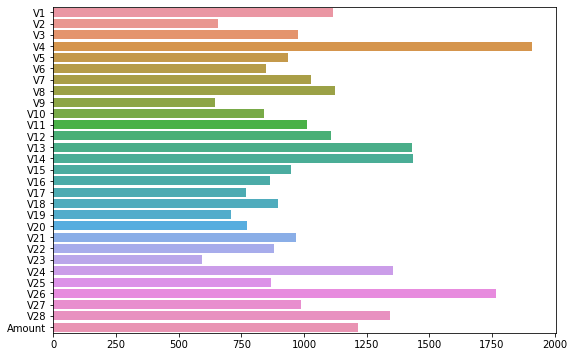

In [ ]:
plt.figure(figsize = (9, 6))
sns.barplot(LGB.feature_importances_,
            X.columns)
plt.show()

### 8) KNN

In [ ]:
%%time

KNN = KNeighborsClassifier(n_neighbors = 500,
                           n_jobs = -1)

KNN.fit(X_train, y_train)

CPU times: user 1.43 s, sys: 9.03 ms, total: 1.44 s
Wall time: 1.44 s


#### (1) 성능평가

In [ ]:
ac = accuracy_score(y_test, KNN.predict(X_test))
rs = recall_score(y_test, KNN.predict(X_test), pos_label = 1)

res = {'model_id' : 'KNN' , 'model' : 'K-NN' , 'accuracy' : ac , 'recall' : rs}
df_res = df_res.append(res, ignore_index= True)
df_res

,model_id,model,accuracy,recall
0,RF,Random Forest,0.999614,0.837838
1,GBM,GBM,0.999040,0.635135
2,ABC,AdaBoosting,0.999181,0.628378
3,XGB,XGBoosting,0.999579,0.844595
4,LGBM,LGBM,0.999555,0.817568
5,DT,Decision Tree,0.999298,0.810811
6,LR,Logistic Regression,0.999380,0.750000
7,KNN,K-NN,0.998268,0.000000


## Hyperparameter Tuning

### 1) 상위 3개 모델


####(1) Random Forest

In [ ]:
for est in [100, 200, 300] :
  for mf in [3, 4, 5] :
    Model_rf = RandomForestClassifier(criterion = 'entropy',
                            n_estimators = est,
                            max_features = mf,
                            random_state = 2045,
                            n_jobs = -1)
    Model_rf.fit(X_train, y_train)

    print(est, mf, '\n')
    print('accuracy: ' , accuracy_score(y_test, Model_rf.predict(X_test)), '\n')
    print('recall: ' , recall_score(y_test, Model_rf.predict(X_test), pos_label = 1), '\n')


# n_estimator = 100, max_features = 4 이후 유의미한 향상은 없는 것으로 보인다   

100 3 

accuracy:  0.999602073897218 

recall:  0.831081081081081 

100 4 

accuracy:  0.9996137776061234 

recall:  0.8378378378378378 

100 5 

accuracy:  0.9996137776061234 

recall:  0.8378378378378378 

200 3 

accuracy:  0.9996371850239341 

recall:  0.8378378378378378 

200 4 

accuracy:  0.999602073897218 

recall:  0.831081081081081 



KeyboardInterrupt: ignored

####(2) XGBoost

In [ ]:
%%time

for est in [500, 1000, 1500, 2000] :
  for lr in [0.6, 0.5, 0.3, 0.2, 0.1, 0.01]:
    for rl in [0.05, 0.1]:
      Model_xgb = XGBClassifier(booster = 'gbtree',
                                n_estimators = est,
                                learning_rate = lr,
                                reg_lambda = rl,
                                n_jobs = -1)
      Model_xgb.fit(X_train, y_train)

      print('XGB-%s-%s-%s' %(est, lr, rl))
      print('accuracy: ' , accuracy_score(y_test, Model_xgb.predict(X_test)))
      print('recall: ' , recall_score(y_test, Model_xgb.predict(X_test), pos_label = 1))


# 학습율을 낮추며 튜닝해봤으나 향상되지 않았다

XGB-500-0.6-0.05
accuracy:  0.9995669627705019
recall:  0.831081081081081
XGB-500-0.6-0.1
accuracy:  0.9995201479348805
recall:  0.8175675675675675
XGB-500-0.5-0.05
accuracy:  0.9995552590615966
recall:  0.8175675675675675
XGB-500-0.5-0.1
accuracy:  0.9995552590615966
recall:  0.831081081081081
XGB-500-0.3-0.05
accuracy:  0.9995552590615966
recall:  0.831081081081081
XGB-500-0.3-0.1
accuracy:  0.9995318516437859
recall:  0.831081081081081


KeyboardInterrupt: ignored

In [ ]:
%%time

for lr in [0.6, 0.5, 0.3]:
  Model_xgb = XGBClassifier(booster = 'gbtree',
                            n_estimators = 2000,
                            learning_rate = lr,
                            n_jobs = -1)
  Model_xgb.fit(X_train, y_train)

  print('XGB-2000-%s' %(lr))
  print('accuracy: ' , accuracy_score(y_test, Model_xgb.predict(X_test)))
  print('recall: ' , recall_score(y_test, Model_xgb.predict(X_test), pos_label = 1))

# 튜닝으로 좋은 값 찾기 실패!

XGB-2000-0.6
accuracy:  0.9995552590615966
recall:  0.8243243243243243


KeyboardInterrupt: ignored

#### (3) LGBM

In [ ]:
%%time

for est in [1000, 1500, 2000] :
  for lr in [0.01, 0.001]:
    Model_lgb = LGBMClassifier(n_estimators = est,
                    learning_rate = lr,
                    n_jobs = -1)
    
    Model_lgb.fit(X_train, y_train)

    print('LGB-%s-%s' %(est, lr))
    print('accuracy: ' , accuracy_score(y_test, Model_lgb.predict(X_test)))
    print('recall: ' , recall_score(y_test, Model_lgb.predict(X_test), pos_label = 1))


# n_estimator = 2000, learning_rate = 0.01 일 때 0.831081081081081까지 향상

LGB-1000-0.01
accuracy:  0.9995786664794073
recall:  0.8175675675675675
LGB-1000-0.001
accuracy:  0.9994616293903538
recall:  0.7364864864864865
LGB-1500-0.01
accuracy:  0.9995786664794073
recall:  0.8175675675675675
LGB-1500-0.001
accuracy:  0.9995435553526912
recall:  0.7837837837837838
LGB-2000-0.01
accuracy:  0.999602073897218
recall:  0.831081081081081
LGB-2000-0.001
accuracy:  0.9995552590615966
recall:  0.8040540540540541
CPU times: user 12min 40s, sys: 2.1 s, total: 12min 42s
Wall time: 6min 27s


In [ ]:
res = {'model_id' : 'LGBM2' , 'model' : 'LGBM' , 'accuracy' : 0.999602 , 'recall' : 0.831081}
df_res = df_res.append(res, ignore_index= True)
df_res

,model_id,model,accuracy,recall
0,RF,Random Forest,0.999614,0.837838
1,GBM,GBM,0.999040,0.635135
2,ABC,AdaBoosting,0.999181,0.628378
3,XGB,XGBoosting,0.999579,0.844595
4,LGBM,LGBM,0.999555,0.817568
5,DT,Decision Tree,0.999298,0.810811
6,LR,Logistic Regression,0.999380,0.750000
7,KNN,K-NN,0.998268,0.000000
8,LGBM2,LGBM,0.999602,0.831081


## 10. 최종 성능 비교

In [ ]:
df_res.sort_values(by = 'recall' , ascending = False)

,model_id,model,accuracy,recall
9,XGB2,XGBoosting,0.999637,0.851351
3,XGB,XGBoosting,0.999579,0.844595
0,RF,Random Forest,0.999614,0.837838
8,LGBM2,LGBM,0.999602,0.831081
4,LGBM,LGBM,0.999555,0.817568
5,DT,Decision Tree,0.999298,0.810811
6,LR,Logistic Regression,0.999380,0.750000
1,GBM,GBM,0.999040,0.635135
2,ABC,AdaBoosting,0.999181,0.628378
7,KNN,K-NN,0.998268,0.000000


- 느낀점
  - 튜닝으로 score를 올리기가 쉽지 않다